# tushare for python2

In [1]:
import tushare as ts

In [2]:
import pandas as pd
import numpy as np
import pickle

In [86]:
# ts.set_token("e49181dda89442ffed7d4ce0dfed0292f0d30c35591b60bc23b4bd84") # 设置token

In [4]:
try:
    from urllib.request import urlopen, Request
except ImportError:
    from urllib2 import urlopen, Request

In [5]:
print(ts.__version__)

1.2.15


# tushare 0.4.3 老版所有接口

In [ ]:
# ts.get_hist_data('600848') #一次性获取全部日k线数据 # 历史行情 # 丢失数据 # 统计有多少个股缺失数据
ts.get_h_data('002337') #前复权 # 复权数据
ts.get_k_data(code="000008",start="2017-09-01",end="2018-11-16") # 没有当天的价格 # better than get_hist_data 
ts.get_today_all() # 一次性获取当前交易所有股票的行情数据
# ts.get_tick_data('600848',date='2014-01-09') # 历史分笔 #API被封
ts.get_realtime_quotes('000581') # 实时分笔 # 还不知怎么利用 超短线
# ts.get_today_ticks('601333') # 当日历史分笔 # fail
ts.get_index() # 大盘指数行情列表
# ts.get_sina_dd('600848', date='2015-12-24') #默认400手 大单交易数据 # fail

In [41]:
# ts.get_hist_data('000008',start="2017-09-01",end="2018-11-16") #（sh=上证指数 sz=深圳成指 hs300=沪深300指数 sz50=上证50 zxb=中小板 cyb=创业板）
# ts.get_hist_data('sz',start="2017-09-01",end="2018-11-16")#获取深圳成指k线数据
# ts.get_h_data('002337', start='2015-01-01', end='2015-03-16') #两个日期之间的前复权数据
# ts.get_today_all()
# ts.get_realtime_quotes('000581')
# ts.get_index()

In [ ]:
df = ts.profit_data(top=60) # 分配预案
# df.sort('shares',ascending=False) # 分配预案
ts.forecast_data(2014,2) # 业绩预告
ts.xsg_data() # 限售股解禁
ts.fund_holdings(2014, 4) # 基金持股
ts.new_stocks() # 新股数据
# ts.sh_margins(start='2015-01-01', end='2015-04-19') # 融资融券（沪市）fail
ts.sz_margins(start='2015-01-01', end='2015-04-19') # 融资融券（深市)
ts.sz_margin_details('2015-04-20') # #深市融资融券明细一次只能获取一天的明细数据

In [56]:
# ts.profit_data(year=2018, top=60)
# ts.forecast_data(2018,3)
# ts.xsg_data(year=2018, month=12)
# ts.fund_holdings(2018, 3)
# ts.new_stocks()
# ts.sz_margins(start='2015-01-01', end='2015-04-19')
# ts.sz_margin_details('2015-04-20')

In [ ]:
ts.get_industry_classified() # 行业分类
ts.get_concept_classified() # 概念分类
ts.get_area_classified() # 地域分类
ts.get_sme_classified() # 中小板分类
ts.get_gem_classified() # 创业板分类
ts.get_st_classified() # 风险警示板分类
ts.get_hs300s() # 沪深300成份及权重
ts.get_sz50s() # 上证50成份股
ts.get_zz500s() # 中证500成份股
#ts.get_terminated() # 终止上市股票列表 # fail
#ts.get_suspended() # 暂停上市股票列表 # fail

In [70]:
#ts.get_industry_classified() # 行业分类
#ts.get_concept_classified() # 概念分类
#ts.get_area_classified() # 地域分类
#ts.get_sme_classified() # 中小板分类
#ts.get_gem_classified() # 创业板分类
#ts.get_st_classified() # 风险警示板分类
#ts.get_hs300s() # 沪深300成份及权重
#ts.get_sz50s() # 上证50成份股
#ts.get_zz500s() # 中证500成份股

In [ ]:
ts.get_stock_basics() # 股票列表
ts.get_report_data(2014,3) # 业绩报告（主表）
ts.get_profit_data(2014,3) # 盈利能力
ts.get_operation_data(2014,3) # 营运能力
ts.get_growth_data(2014,3) # 成长能力
ts.get_debtpaying_data(2014,3) # 偿债能力
ts.get_cashflow_data(2014,3) # 现金流量

In [78]:
# ts.get_stock_basics()
# ts.get_report_data(2018,3)
# ts.get_profit_data(2018,3)
# ts.get_operation_data(2018,3)
# ts.get_growth_data(2018,3)
# ts.get_debtpaying_data(2018,3)
# ts.get_cashflow_data(2018,3)

In [ ]:
ts.top_list('2016-06-12') # 每日龙虎榜列表
ts.cap_tops() # 个股上榜统计
ts.broker_tops() # 营业部上榜统计
ts.inst_tops() # 机构席位追踪
ts.inst_detail() # 机构成交明细

In [85]:
# ts.top_list('2018-11-16')
# ts.cap_tops(days=5)
# ts.broker_tops(days=5)
# ts.inst_tops(days=5)
# ts.inst_detail()

# tushare 1.2.15 新版所有接口

In [87]:
pro = ts.pro_api() # 初始化pro接口
#查询当前所有正常上市交易的股票列表
df = pro.trade_cal(exchange='', start_date='20180901', end_date='20181001', 
                   fields='exchange,cal_date,is_open,pretrade_date', is_open='0')
data = pro.stock_basic(exchange='', list_status='L', fields='ts_code,symbol,name,area,industry,list_date')

In [91]:
pro.stock_basic(exchange='', list_status='L', fields='ts_code,symbol,name,area,industry,list_date')

,ts_code,symbol,name,area,industry,list_date
0,000001.SZ,000001,平安银行,深圳,银行,19910403
1,000002.SZ,000002,万科A,深圳,全国地产,19910129
2,000004.SZ,000004,国农科技,深圳,生物制药,19910114
3,000005.SZ,000005,世纪星源,深圳,房产服务,19901210
4,000006.SZ,000006,深振业A,深圳,区域地产,19920427
5,000007.SZ,000007,全新好,深圳,酒店餐饮,19920413
6,000008.SZ,000008,神州高铁,北京,运输设备,19920507
7,000009.SZ,000009,中国宝安,深圳,综合类,19910625
8,000010.SZ,000010,美丽生态,深圳,建筑施工,19951027
9,000011.SZ,000011,深物业A,深圳,区域地产,19920330


In [92]:
pro.query('stock_basic', exchange='', list_status='L', fields='ts_code,symbol,name,area,industry,list_date')

,ts_code,symbol,name,area,industry,list_date
0,000001.SZ,000001,平安银行,深圳,银行,19910403
1,000002.SZ,000002,万科A,深圳,全国地产,19910129
2,000004.SZ,000004,国农科技,深圳,生物制药,19910114
3,000005.SZ,000005,世纪星源,深圳,房产服务,19901210
4,000006.SZ,000006,深振业A,深圳,区域地产,19920427
5,000007.SZ,000007,全新好,深圳,酒店餐饮,19920413
6,000008.SZ,000008,神州高铁,北京,运输设备,19920507
7,000009.SZ,000009,中国宝安,深圳,综合类,19910625
8,000010.SZ,000010,美丽生态,深圳,建筑施工,19951027
9,000011.SZ,000011,深物业A,深圳,区域地产,19920330


In [8]:
# 获取历史复权数据，分为前复权和后复权数据，接口提供股票上市以来所有历史数据，默认为前复权
df = ts.get_stock_basics()
# 获取个股首个上市日期
#date = df.ix['600848']['timeToMarket'] #上市日期YYYYMMDD
# date = df.loc['600848']['timeToMarket'] #上市日期YYYYMMDD

In [105]:
# 过滤上市不足半年的新股
# 过滤业绩亏损的股票
# 过滤质押比35%以上的股票
#
# 过滤营业额不足1亿的
# 过滤营业利润不足1千万的
# 过滤st股票
# 过滤有重大解禁的股票

In [9]:
df[df.timeToMarket>20180401].head(3) # 58支个股上市不足半年

,name,industry,area,pe,outstanding,totals,totalAssets,liquidAssets,fixedAssets,reserved,...,bvps,pb,timeToMarket,undp,perundp,rev,profit,gpr,npr,holders
code,,,,,,,,,,,,,,,,,,,,,
601319,N人保,保险,北京,13.17,10.11,442.24,1.040058e+08,0.00,2341800.00,401200.00,...,3.42,1.41,20181116,7744300.00,1.75,0.0,0.0,0.00,3.07,864594.0
603220,贝通信,通信设备,湖北,43.85,0.84,3.38,2.274616e+05,194429.00,16596.36,21596.92,...,3.27,3.80,20181115,33116.35,0.98,0.0,0.0,21.11,7.35,80001.0
300674,宇信科技,软件服务,北京,85.67,0.40,4.00,2.609500e+05,162169.22,12474.46,39784.35,...,3.51,6.68,20181107,48025.76,1.20,0.0,0.0,34.31,7.73,76796.0


In [10]:
df = df[df.timeToMarket<=20180401] 

In [11]:
df[df.timeToMarket==0]

,name,industry,area,pe,outstanding,totals,totalAssets,liquidAssets,fixedAssets,reserved,...,bvps,pb,timeToMarket,undp,perundp,rev,profit,gpr,npr,holders
code,,,,,,,,,,,,,,,,,,,,,
002943,宇晶股份,专用机械,湖南,0.0,0.0,0.0,57487.73,42262.92,0.00,0.00,...,0.0,0.0,0,0.00,0.0,0.0,0.0,0.00,22.80,0.0
002942,新农股份,农药化肥,浙江,0.0,0.0,0.0,68233.63,38631.28,0.00,0.00,...,0.0,0.0,0,0.00,0.0,0.0,0.0,0.00,16.65,0.0
002941,新疆交建,建筑施工,新疆,0.0,0.0,0.0,964207.63,784070.88,33995.96,36995.84,...,0.0,0.0,0,65454.41,0.0,0.0,0.0,12.92,13.18,0.0
603187,海容冷链,机械基件,山东,0.0,0.0,0.0,120083.88,0.00,0.00,0.00,...,0.0,0.0,0,0.00,0.0,0.0,0.0,0.00,13.52,0.0


In [12]:
df = df[df.timeToMarket!=0] # 过滤即将上市的

In [13]:
min(df.timeToMarket) # check

19901210

In [15]:
df[df.esp<=0]

,name,industry,area,pe,outstanding,totals,totalAssets,liquidAssets,fixedAssets,reserved,...,bvps,pb,timeToMarket,undp,perundp,rev,profit,gpr,npr,holders
code,,,,,,,,,,,,,,,,,,,,,
002164,宁波东力,电气设备,浙江,0.00,4.40,6.99,874627.38,779127.31,60392.11,234646.17,...,0.26,13.54,20070823,-290541.25,-4.15,112.69,-4796.91,2.45,-26.92,44012.0
000068,华控赛格,元器件,深圳,0.00,10.07,10.07,331740.44,115829.85,16985.25,119316.82,...,0.60,7.76,19970611,-175029.06,-1.74,-18.23,-489.78,33.95,-35.71,32199.0
002045,国光电器,元器件,广东,0.00,4.16,4.68,520577.25,290482.50,71130.68,82880.67,...,3.87,1.49,20050523,37828.07,0.81,15.61,-165.27,13.94,-2.11,36482.0
002417,深南股份,通信设备,江苏,0.00,2.23,2.70,40476.92,29325.53,220.66,40765.68,...,1.17,8.07,20100601,-39024.95,-1.45,-4.57,-488.62,40.98,-35.73,19780.0
300126,锐奇股份,轻工机械,上海,0.00,2.11,3.04,128471.22,90173.40,16545.64,47334.51,...,3.33,1.84,20101013,17928.90,0.59,18.39,-1314.41,10.69,-4.68,16259.0
600165,新日恒力,钢加工,宁夏,8209.87,6.85,6.85,226803.30,146751.73,15972.15,33692.09,...,1.26,4.17,19980529,-19049.27,-0.28,-57.93,141.91,7.52,0.07,52832.0
002209,达 意 隆,轻工机械,广东,0.00,1.54,1.95,145681.02,98940.38,37200.56,22323.70,...,3.24,2.51,20080130,18003.43,0.92,3.28,95.08,23.92,-0.07,16587.0
300682,朗新科技,软件服务,江苏,0.00,1.62,4.17,166970.52,149203.38,1519.12,49026.21,...,2.57,6.06,20170801,25753.80,0.62,-7.53,-485.45,38.47,-53.43,16312.0
600119,长江投资,仓储物流,上海,0.00,3.07,3.07,211797.02,110333.61,36789.15,33174.71,...,1.69,5.19,19980115,-17911.48,-0.58,-62.52,-1301.13,12.24,-34.03,41250.0


In [16]:
df = df[df.esp>0]

In [17]:
zy_df = pd.read_csv("gpzyhgmx_20181104_20181110.txt", sep="\t", dtype={'code': str})

In [18]:
zy_df.index = zy_df.code

In [19]:
zy_df_dange = zy_df[zy_df.zyRatio>35]

In [20]:
zy_df_dange.head()

,date,code,name,count,unlimit,limit,totalA,zyRatio
code,,,,,,,,
000018,2018-11-09,000018,____,74.0,59490.36,5599.58,143444.18,45.38
000020,2018-11-09,000020,___A,2.0,11610.00,0.00,18116.54,64.09
000034,2018-11-09,000034,____,30.0,3965.00,26048.87,65407.04,45.89
000035,2018-11-09,000035,____,30.0,48336.86,0.00,135152.14,35.76
000038,2018-11-09,000038,___,47.0,7923.67,26654.16,52277.74,66.14


In [21]:
df = df.loc[list(set(df.index) - set(zy_df_dange.index))]

In [22]:
df

,name,industry,area,pe,outstanding,totals,totalAssets,liquidAssets,fixedAssets,reserved,...,bvps,pb,timeToMarket,undp,perundp,rev,profit,gpr,npr,holders
code,,,,,,,,,,,,,,,,,,,,,
300235,方直科技,软件服务,深圳,58.64,1.06,1.68,6.374580e+04,45628.18,9410.76,28174.75,...,3.59,2.71,20110629,13247.86,0.79,16.18,78.09,61.88,22.51,14811.0
300465,高伟达,软件服务,北京,96.76,4.27,4.47,2.387985e+05,118259.60,10632.17,33981.19,...,2.47,2.90,20150528,30683.44,0.69,22.34,118.30,23.64,2.41,46399.0
600782,新钢股份,普钢,江西,3.35,31.89,31.89,3.741151e+06,2495530.75,1009198.50,560817.81,...,5.34,1.04,19961225,765520.81,2.40,14.86,187.10,14.97,9.68,46325.0
002563,森马服饰,服饰,浙江,15.16,18.39,27.00,1.520736e+06,1056421.63,101524.77,253505.67,...,3.96,2.40,20110311,451783.50,1.67,21.41,25.66,38.77,13.03,23564.0
300047,天源迪科,软件服务,深圳,50.28,3.04,3.99,4.206702e+05,254252.52,40439.28,171853.44,...,7.23,1.82,20100120,69998.71,1.75,20.50,136.50,23.96,4.05,21832.0
600622,光大嘉宝,区域地产,上海,12.34,8.69,11.54,2.178251e+06,1250834.75,20156.59,176843.88,...,4.90,1.26,19921203,239382.67,2.08,105.87,29.66,54.20,14.39,28314.0
002636,金安国纪,元器件,上海,18.46,2.46,7.28,4.254554e+05,319551.38,75516.13,19133.28,...,3.38,2.37,20111125,147387.13,2.02,9.69,-40.21,17.89,8.31,53181.0
002779,中坚科技,农用机械,浙江,153.61,0.40,1.32,8.146338e+04,49280.67,18454.43,19537.85,...,4.83,3.49,20151209,27478.31,2.08,-11.21,-63.56,19.14,3.55,10196.0
300383,光环新网,电信运营,北京,34.73,13.67,15.40,1.136340e+06,354499.22,397050.38,390459.75,...,4.51,3.17,20140129,127815.92,0.83,54.78,46.14,20.35,10.60,56760.0


In [23]:
df[df.pe>100]

,name,industry,area,pe,outstanding,totals,totalAssets,liquidAssets,fixedAssets,reserved,...,bvps,pb,timeToMarket,undp,perundp,rev,profit,gpr,npr,holders
code,,,,,,,,,,,,,,,,,,,,,
002779,中坚科技,农用机械,浙江,153.61,0.40,1.32,81463.38,49280.67,18454.43,19537.85,...,4.83,3.49,20151209,27478.31,2.08,-11.21,-63.56,19.14,3.55,10196.0
000790,泰合健康,中成药,四川,132.70,5.60,5.60,103379.78,73036.18,22580.77,3958.06,...,1.46,3.42,19980327,11970.57,0.21,6.08,130.25,67.15,3.68,53898.0
000622,恒立实业,汽车配件,湖南,3067.72,4.25,4.25,39539.75,37755.51,1750.70,19628.25,...,0.44,23.62,19961107,-43413.94,-1.02,43.38,109.19,20.72,2.16,17885.0
600310,桂东电力,水力发电,广西,250.55,8.28,8.28,1477545.88,581686.38,282561.41,27400.96,...,2.12,1.83,20010228,18600.51,0.22,31.58,-44.49,5.78,0.10,39849.0
002459,天业通联,工程机械,河北,256.78,3.87,3.89,145392.81,77021.43,34008.85,167438.84,...,3.27,3.62,20100810,-82382.10,-2.12,21.57,151.74,18.03,5.50,16478.0
300048,合康新能,电气设备,北京,107.92,9.76,11.29,454747.91,244094.30,125215.17,87634.61,...,2.21,1.22,20100120,48724.25,0.43,11.76,-57.65,28.65,2.16,47212.0
002213,特 尔 佳,汽车配件,深圳,588.55,1.97,2.06,42270.48,33680.85,7400.45,77.23,...,1.79,4.99,20080201,13571.29,0.66,-15.29,-79.04,36.84,3.20,10639.0
600539,*ST狮头,水泥,山西,133.45,2.30,2.30,49040.46,44170.09,1313.96,54635.78,...,1.86,3.66,20010824,-38506.80,-1.67,0.89,125.61,24.60,14.84,8862.0
300010,立思辰,软件服务,北京,810.51,6.31,8.73,880098.63,299903.13,28335.01,378157.41,...,6.25,1.50,20091030,85573.49,0.98,2.73,-88.45,45.51,0.69,46924.0


In [135]:
# df = df[df.pe<100]

In [18]:
df[df.outstanding>100]

,name,industry,area,pe,outstanding,totals,totalAssets,liquidAssets,fixedAssets,reserved,...,bvps,pb,timeToMarket,undp,perundp,rev,profit,gpr,npr,holders
code,,,,,,,,,,,,,,,,,,,,,
601186,中国铁建,建筑施工,北京,8.92,115.03,135.80,8.994426e+07,7.005650e+07,4847735.00,4041436.50,...,10.61,1.04,20080310,8.797689e+06,6.48,6.40,20.11,9.99,2.58,284429.0
600036,招商银行,银行,深圳,7.97,206.29,252.20,6.508681e+08,0.000000e+00,5323000.00,6752300.00,...,19.49,1.46,20020409,2.777490e+07,11.01,13.59,14.58,0.00,35.80,234123.0
600104,上汽集团,汽车整车,上海,8.45,115.03,116.83,7.343140e+07,4.173878e+07,6542812.50,5479218.00,...,19.75,1.35,19971125,1.108212e+07,9.49,10.82,12.31,13.37,4.17,96641.0
601328,交通银行,银行,上海,5.69,392.51,742.63,9.391537e+08,0.000000e+00,14317800.00,11366300.00,...,8.38,0.70,20070515,1.203210e+07,1.62,5.42,5.30,0.00,36.31,354454.0
601985,中国核电,新型电力,北京,16.98,155.65,155.65,3.195962e+07,3.902097e+06,17275314.00,1273703.50,...,2.93,1.91,20150610,1.474113e+06,0.95,10.41,-6.48,44.04,13.67,471857.0
601988,中国银行,银行,北京,5.19,2107.66,2943.88,2.092566e+09,0.000000e+00,21817300.00,14212600.00,...,5.02,0.72,20060705,6.987000e+07,2.37,3.32,5.34,0.00,40.75,745892.0
601989,中国重工,船舶,北京,51.54,183.62,228.80,2.067867e+07,1.492952e+07,3188343.75,4516226.50,...,3.71,1.15,20091216,1.515534e+06,0.66,15.35,28.03,10.35,4.74,826983.0
601668,中国建筑,建筑施工,北京,6.23,416.24,419.85,1.819756e+08,1.326445e+08,3497481.50,1292857.50,...,5.11,1.06,20090729,1.553137e+07,3.70,9.03,5.89,10.49,3.25,569368.0
601998,中信银行,银行,北京,5.72,319.05,489.35,5.864796e+08,0.000000e+00,2164600.00,5897700.00,...,7.95,0.72,20070427,1.763160e+07,3.60,5.27,5.93,0.00,30.32,173469.0


In [139]:
# df = df[df.outstanding<100]

In [33]:
profit_df = ts.get_profit_data(2018,3)

[Getting data:]############################################################

In [34]:
profit_df.index = profit_df.code

In [146]:
profit_df = profit_df[profit_df.business_income>500]

In [149]:
profit_df = profit_df[profit_df.net_profits>100]

In [154]:
df = df.loc[list(set(df.index) & set(profit_df.index))]

In [36]:
df.index

Index([u'000099', u'000096', u'000090', u'603648', u'603139', u'603138',
       u'002193', u'603136', u'603131', u'600781',
       ...
       u'000898', u'300645', u'300644', u'300647', u'300641', u'300640',
       u'300643', u'300642', u'300649', u'300648'],
      dtype='object', name=u'code', length=2634)

In [112]:
# initial parameter
start='2017-10-01'
end='2018-11-15'
stock_df = pd.DataFrame()

In [113]:
for code in df.index:
    # code = "000008" # for test
    # temp_pv = ts.get_hist_data(code, start=start, end=end) # 经常搞不到数据
    temp_pv = ts.get_k_data(code, start=start, end=end) # 顺序reverse # 比较稳定
    #print(temp_pv)
    # temp_pv.head()
    if len(temp_pv) < 80:
        print(code, "day less than 80")
        continue
    max_p = max(temp_pv.close)
    min_p = min(temp_pv.close)
    last_p = list(temp_pv.close)[-1]
    #print(last_p)
    posH = (max_p-last_p)/max_p
    posL = (last_p-min_p)/min_p
    fluct = np.mean(sorted(((temp_pv.high-temp_pv.low)/temp_pv.close)[-10:], reverse=True)[:5])
    relative_v = np.mean(sorted(temp_pv.volume[-10:], reverse=True)[:5])/np.mean(temp_pv.volume[-30:])
    ma10 = np.mean(list(temp_pv.close)[-10:])
    ma20 = np.mean(list(temp_pv.close)[-20:])
    ma30 = np.mean(list(temp_pv.close)[-30:])
    temp_stock = {
        "last_p" : last_p,
        "posH" : round(posH, 2),
        "posL" : round(posL, 2),
        "fluct" : round(fluct, 2),
        "mean10" : int(last_p > ma10),
        "mean20" : int(last_p > ma20),
        "mean30" : int(last_p > ma30),
        "relative_v" : round(relative_v, 2)
    }
    stock_df = stock_df.append(pd.DataFrame(temp_stock, index=[code]), )
    print(len(stock_df))
    # break

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
('000526', 'day less than 80')
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
2

1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
('000540', 'day less than 80')
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014

In [122]:
stock_df["code"] = stock_df.index

In [123]:
stock_df.head()

,fluct,last_p,mean10,mean20,mean30,posH,posL,relative_v,code
000099,0.04,6.06,1,1,1,0.47,0.18,1.72,000099
000096,0.04,9.19,1,1,1,0.36,0.14,1.68,000096
000090,0.03,5.38,1,1,1,0.42,0.12,1.27,000090
603648,0.05,12.11,0,1,0,0.63,0.13,1.46,603648
603139,0.03,17.15,1,1,1,0.45,0.15,1.71,603139


In [124]:
stock_df_2 = df.loc[stock_df.index]

In [126]:
stock_df_2["code"] = stock_df_2.index

In [127]:
stock_df_2

,name,industry,area,pe,outstanding,totals,totalAssets,liquidAssets,fixedAssets,reserved,...,pb,timeToMarket,undp,perundp,rev,profit,gpr,npr,holders,code
000099,中信海直,空运,深圳,31.30,6.06,6.06,546831.81,175131.13,280055.91,103327.21,...,1.21,20000731,116533.67,1.92,11.19,4.79,24.35,8.90,61614.0,000099
000096,广聚能源,石油贸易,深圳,37.87,5.11,5.28,265414.41,153291.81,6630.66,35133.70,...,1.97,20000724,121982.45,2.31,43.47,-19.95,9.40,7.70,32169.0,000096
000090,天健集团,建筑施工,深圳,33.23,9.28,14.37,2959995.75,2587319.50,30278.86,204128.84,...,1.23,19990721,200777.23,1.40,2.15,-67.91,17.82,3.76,35362.0,000090
603648,畅联股份,仓储物流,上海,26.65,2.73,3.69,196679.02,116609.61,28302.14,90418.13,...,2.77,20170913,27952.14,0.76,3.98,4.88,26.09,13.65,34160.0,603648
603139,康惠制药,中成药,陕西,39.12,0.54,1.00,100243.56,83385.67,6048.27,41201.68,...,1.85,20170421,37192.00,3.72,6.74,-9.66,52.69,13.23,11849.0,603139
603138,海量数据,软件服务,北京,55.81,0.47,1.50,62074.86,55639.76,690.67,11407.62,...,7.50,20170306,14808.11,0.98,2.11,-6.00,27.24,10.80,17631.0,603138
002193,如意集团,纺织,山东,43.57,2.30,2.62,485040.44,304138.81,155896.38,159565.73,...,1.38,20071207,63994.57,2.45,21.14,83.34,23.01,6.88,11958.0,002193
603136,天目湖,旅游景点,江苏,19.87,0.20,0.80,111044.21,27681.55,68435.55,35576.37,...,3.07,20170927,34643.03,4.33,4.68,20.86,67.16,25.75,10483.0,603136
603131,上海沪工,专用机械,上海,50.05,0.50,2.00,96439.86,70296.59,12740.28,17166.15,...,4.46,20160607,26800.50,1.34,9.29,-27.01,22.68,7.87,14785.0,603131
600781,辅仁药业,中成药,河南,10.33,1.78,6.27,1066788.25,592691.63,329821.25,189848.80,...,1.92,19961218,263320.50,4.20,12.46,154.02,45.72,15.33,16281.0,600781


In [129]:
stock_df_3 = pd.merge(stock_df_2, stock_df, on=["code"])

In [133]:
stock_df_3.index = stock_df_3["code"]

In [131]:
stock_df_3["market_value"] = stock_df_3.outstanding * stock_df_3.last_p

In [134]:
stock_df_3

,name,industry,area,pe,outstanding,totals,totalAssets,liquidAssets,fixedAssets,reserved,...,code,fluct,last_p,mean10,mean20,mean30,posH,posL,relative_v,market_value
code,,,,,,,,,,,,,,,,,,,,,
000099,中信海直,空运,深圳,31.30,6.06,6.06,546831.81,175131.13,280055.91,103327.21,...,000099,0.04,6.06,1,1,1,0.47,0.18,1.72,36.7236
000096,广聚能源,石油贸易,深圳,37.87,5.11,5.28,265414.41,153291.81,6630.66,35133.70,...,000096,0.04,9.19,1,1,1,0.36,0.14,1.68,46.9609
000090,天健集团,建筑施工,深圳,33.23,9.28,14.37,2959995.75,2587319.50,30278.86,204128.84,...,000090,0.03,5.38,1,1,1,0.42,0.12,1.27,49.9264
603648,畅联股份,仓储物流,上海,26.65,2.73,3.69,196679.02,116609.61,28302.14,90418.13,...,603648,0.05,12.11,0,1,0,0.63,0.13,1.46,33.0603
603139,康惠制药,中成药,陕西,39.12,0.54,1.00,100243.56,83385.67,6048.27,41201.68,...,603139,0.03,17.15,1,1,1,0.45,0.15,1.71,9.2610
603138,海量数据,软件服务,北京,55.81,0.47,1.50,62074.86,55639.76,690.67,11407.62,...,603138,0.06,20.62,1,1,1,0.44,0.23,2.22,9.6914
002193,如意集团,纺织,山东,43.57,2.30,2.62,485040.44,304138.81,155896.38,159565.73,...,002193,0.03,13.51,0,0,1,0.21,0.40,2.15,31.0730
603136,天目湖,旅游景点,江苏,19.87,0.20,0.80,111044.21,27681.55,68435.55,35576.37,...,603136,0.06,31.34,1,1,1,0.43,0.34,2.06,6.2680
603131,上海沪工,专用机械,上海,50.05,0.50,2.00,96439.86,70296.59,12740.28,17166.15,...,603131,0.06,15.08,0,1,1,0.47,0.27,2.52,7.5400


In [ ]:
ts.get_h_data('002337') #前复权
ts.get_h_data('002337', autype='hfq') #后复权
ts.get_h_data('002337', autype=None) #不复权
ts.get_h_data('002337', start='2015-01-01', end='2015-03-16') #两个日期之间的前复权数据

ts.get_h_data('399106', index=True) #深圳综合指数

In [141]:
# 实时行情
# 一次性获取当前交易所有股票的行情数据
ts.get_today_all().head()

[Getting data:]############################################################

,code,name,changepercent,trade,open,high,low,settlement,volume,turnoverratio,amount,per,pb,mktcap,nmc
0,603999,读者传媒,-1.657,5.34,5.35,5.43,5.21,5.43,5259540,2.28279,27859862,40.763,1.811,3.075840e+05,1.230336e+05
1,603998,方盛制药,1.416,5.73,5.65,5.78,5.64,5.65,2553600,0.60057,14539697,40.929,2.358,2.455664e+05,2.436377e+05
2,603997,继峰股份,0.724,8.35,8.33,8.36,8.26,8.29,1321750,0.20980,10988340,18.152,2.938,5.324955e+05,5.260500e+05
3,603996,中新科技,-0.110,9.07,9.11,9.15,8.96,9.08,3438198,3.32917,31073145,18.510,1.733,2.722360e+05,9.367043e+04
4,603993,洛阳钼业,0.478,4.20,4.19,4.22,4.15,4.18,75484667,0.42729,315726373,30.000,2.198,9.071681e+06,7.419624e+06


In [62]:
from tushare.stock import cons as ct
from bs4 import BeautifulSoup
import requests
import time
def get_tick_data(code=None, start=None, end=None, retry_count=10, pause=0.01, src='sn', proxies=None):
    """
        获取分笔数据
    Parameters
    ------
        code:string
                  股票代码 e.g. 600848
        date:string
                  日期 format: YYYY-MM-DD
        retry_count : int, 默认 3
                  如遇网络等问题重复执行的次数
        pause : int, 默认 0
                 重复请求数据过程中暂停的秒数，防止请求间隔时间太短出现的问题
        src : 数据源选择，可输入sn(新浪)、tt(腾讯)、nt(网易)，snn（新浪new）, 默认sn
     return
     -------
        DataFrame 当日所有股票交易数据(DataFrame)
              属性:成交时间、成交价格、价格变动，成交手、成交金额(元)，买卖类型
    """
    #if (src.strip() not in ct.TICK_SRCS):
    #    print(ct.TICK_SRC_ERROR)
    #    return None
    symbol = ct._code_to_symbol(code)
    #symbol_dgt = ct._code_to_symbol_dgt(code)
    # temp_date = date.split("-")
    # date2 = "-".join([temp_date[0], temp_date[1], str(int(temp_date[2])+1)]) # bug when 10-31
    # datestr = date.replace('-', '')
    #url = {
    #        ct.TICK_SRCS[0] : ct.TICK_PRICE_URL % (ct.P_TYPE['http'], ct.DOMAINS['sf'], ct.PAGES['dl'],
    #                            date, symbol),
    #        ct.TICK_SRCS[1] : ct.TICK_PRICE_URL_TT % (ct.P_TYPE['http'], ct.DOMAINS['tt'], ct.PAGES['idx'],
    #                                       symbol, datestr),
    #        ct.TICK_SRCS[2] : ct.TICK_PRICE_URL_NT % (ct.P_TYPE['http'], ct.DOMAINS['163'], date[0:4], 
    #                                     datestr, symbol_dgt)
    #         }
    headers = {'User-Agent':'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/52.0.2743.116 Safari/537.36'}
    user_agents = ['Mozilla/5.0 (Windows NT 6.1; rv:2.0.1) Gecko/20100101 Firefox/4.0.1',
                   'Mozilla/5.0 (Windows; U; Windows NT 6.1; en-us) AppleWebKit/534.50 (KHTML, like Gecko) Version/5.1 Safari/534.50',
                   'Opera/9.80 (Windows NT 6.1; U; en) Presto/2.8.131 Version/11.11']
    cookies = dict(uuid='b18f0e70-8705-470d-bc4b-09a8da617e15',
                   UM_distinctid='15d188be71d50-013c49b12ec14a-3f73035d-100200-15d188be71ffd')
    # proxies = {'http':'http://10.10.10.10:8765','https':'https://10.10.10.10:8765'}
    
    url = "http://market.finance.sina.com.cn/pricehis.php?symbol=%s&startdate=%s&enddate=%s" % (symbol, start, end)
    for count in range(retry_count):
        print("retry_count", count)
        # time.sleep(pause)
        time.sleep(random.randint(0,1))
        headers = {'User-Agent':random.choice(user_agents)}
        try:
            if src == ct.TICK_SRCS[0]:
                #df = pd.read_excel(url[src])
                #df.columns = ct.TICK_COLUMNS
                # method1
                res = requests.get(url, headers = headers, cookies = cookies, proxies = proxies)
                print(res.status_code)
                # method2
                #re = Request(url)
                #res = urlopen(re, timeout=2).read()
                # res = lines.decode('GBK') 
                soup = BeautifulSoup(res.text, 'lxml') # res.text for method1
                tables = soup.select('table')
                df_list = []
                for table in tables:
                    df_list.append(pd.concat(pd.read_html(table.prettify())))
                if not df_list:
                    continue
                df = pd.concat(df_list)
                df.columns = ["price", "volumn", "percent", "graph"]
                df.index = df["price"]
            else:
                re = Request(url[src])
                lines = urlopen(re, timeout=10).read()
                lines = lines.decode('GBK') 
                if len(lines) == 0:
                    return None
                df = pd.read_table(StringIO(lines), names=ct.TICK_COLUMNS, skiprows=[0])      
        except Exception as e:
            print(e)
        else:
            return df
    raise IOError(ct.NETWORK_URL_ERROR_MSG)

In [ ]:
a = None

In [68]:
def get_period_tick_data(code=None, start=None, end=None):
    #code="000008"; start="2018-11-12"; end="2018-11-13"
    merged_dict = {}
    temp_pv = ts.get_k_data(code, start=start, end=end)
    print(temp_pv)
    #for i in temp_pv.date:
    for i in range(len(temp_pv)):
        print(start, end)
        if i == len(temp_pv)-1:
            break
        start = list(temp_pv.date)[i]
        end = list(temp_pv.date)[i+1]
        # print(i)
        tick_df = get_tick_data(code, start, end)
        if tick_df is None:
            continue
        # print(tick_df.head())
        for j in tick_df.index:
            #j = round(j, 2)
            j = float(format(j, '.3g'))
            #j = str(j)
            # print(j)
            if j in merged_dict.keys():
                merged_dict[j] = tick_df.loc[j][1] + merged_dict[j]
            else:
                merged_dict[j] = tick_df.loc[j][1]
    # return sorted(merged_dict.items(), key=lambda item:item[0])
    return merged_dict
        #break

4.32

In [23]:
temp_pv = ts.get_k_data(code="000008", start="2018-10-12", end="2018-11-13")

In [69]:
# merged_dict
period_tick_dict = get_period_tick_data(code="000008", start="2018-10-12", end="2018-11-13")
period_tick_dict

           date  open  close  high   low     volume    code
135  2018-10-12  4.04   3.96  4.13  3.96   502994.0  000008
136  2018-10-15  4.00   3.85  4.04  3.84   327354.0  000008
137  2018-10-16  3.86   3.54  3.90  3.47  1059999.0  000008
138  2018-10-17  3.60   3.68  3.68  3.40   651384.0  000008
139  2018-10-18  3.63   3.58  3.71  3.48   518968.0  000008
140  2018-10-19  3.57   3.92  3.94  3.55   726953.0  000008
141  2018-10-22  3.94   4.01  4.08  3.85   778829.0  000008
142  2018-10-23  4.03   4.04  4.09  3.97   429358.0  000008
143  2018-10-24  4.04   4.07  4.18  4.02   394885.0  000008
144  2018-10-25  3.97   4.17  4.17  3.94   476379.0  000008
145  2018-10-26  4.20   4.25  4.32  4.18   397530.0  000008
146  2018-10-29  4.27   4.21  4.33  4.17   388769.0  000008
147  2018-10-30  4.25   4.30  4.30  4.20   403370.0  000008
148  2018-10-31  4.29   4.41  4.41  4.29   376614.0  000008
149  2018-11-01  4.43   4.35  4.47  4.31   470410.0  000008
150  2018-11-02  4.37   4.37  4.43  4.31

{3.4: 2288400,
 3.41: 626800,
 3.42: 1291000,
 3.43: 3134200,
 3.44: 4203000,
 3.45: 4858400,
 3.46: 7386600,
 3.47: 69801398,
 3.48: 3467070,
 3.49: 4913800,
 3.5: 7481500,
 3.51: 9435020,
 3.52: 13782300,
 3.53: 14339794,
 3.54: 23635906,
 3.55: 23888424,
 3.56: 20119200,
 3.57: 20372600,
 3.58: 20599718,
 3.59: 18339762,
 3.6: 12320398,
 3.61: 12857798,
 3.62: 16456404,
 3.63: 15594424,
 3.64: 15005800,
 3.65: 19934730,
 3.66: 23824400,
 3.67: 14614470,
 3.68: 16176048,
 3.69: 15753944,
 3.7: 12928800,
 3.71: 1597000,
 3.72: 1155800,
 3.73: 5443162,
 3.74: 2683800,
 3.75: 1506200,
 3.76: 2234600,
 3.77: 3627000,
 3.78: 4899400,
 3.79: 4159400,
 3.8: 6151200,
 3.81: 4908200,
 3.82: 8600800,
 3.83: 8685800,
 3.84: 10060588,
 3.85: 6879362,
 3.86: 7026038,
 3.87: 15917222,
 3.88: 9100550,
 3.89: 10930120,
 3.9: 5659070,
 3.91: 7068600,
 3.92: 10034800,
 3.93: 13125200,
 3.94: 35520298,
 3.95: 23245326,
 3.96: 17519568,
 3.97: 10126632,
 3.98: 7624400,
 3.99: 101902424,
 4.0: 30308856,


In [77]:
outfile = open("period_tick_dict.pickle",'wb')
pickle.dump(temp_pv, outfile)
outfile.close()

In [78]:
infile = open("period_tick_dict.pickle",'rb')
new_dict = pickle.load(infile)
infile.close()
# new_dict

,date,open,close,high,low,volume,code
135,2018-10-12,4.04,3.96,4.13,3.96,502994.0,000008
136,2018-10-15,4.00,3.85,4.04,3.84,327354.0,000008
137,2018-10-16,3.86,3.54,3.90,3.47,1059999.0,000008
138,2018-10-17,3.60,3.68,3.68,3.40,651384.0,000008
139,2018-10-18,3.63,3.58,3.71,3.48,518968.0,000008
140,2018-10-19,3.57,3.92,3.94,3.55,726953.0,000008
141,2018-10-22,3.94,4.01,4.08,3.85,778829.0,000008
142,2018-10-23,4.03,4.04,4.09,3.97,429358.0,000008
143,2018-10-24,4.04,4.07,4.18,4.02,394885.0,000008
144,2018-10-25,3.97,4.17,4.17,3.94,476379.0,000008


In [74]:
import matplotlib.pyplot as plt
import math

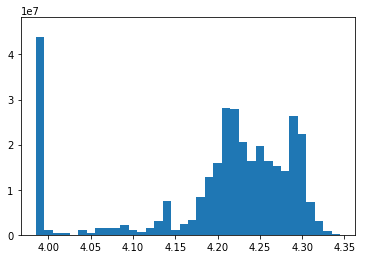

In [86]:
plt.bar(period_tick_dict.keys(), period_tick_dict.values(), width=0.01)

plt.ylim(0, 1.1*max(period_tick_dict.values()))
plt.show()

In [83]:
max(period_tick_dict.values())

43836900

In [49]:
#-*- coding:utf-8 -*-
#import MySQLdb as db
import urllib
import urllib2
import random
from lxml import etree
from bs4 import BeautifulSoup
# from selenium import webdriver
import re
#import time
#import datetime
import os


def get_html(url):
    request = urllib2.Request(url)
    request.add_header("User-Agent","Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/45.0.2454.101 Safari/537.36")
    html = urllib2.urlopen(request)
    print html.getcode()
    return html.read()

#360代理IPHTTPS高匿部分
def fetch_swei360():
    startUrl = 'http://www.swei360.com/free/?page='
    proxys = []
    for i in range(1,8):
        url = startUrl+str(i)
        html = etree.HTML(get_html(url))
        trs = html.xpath('//tr')
        for line in trs[1:]:
            td_type = line.xpath('td[4]/text()')[0].strip()
            if "HTTPS" == td_type:
                td_hide = line.xpath('td[3]/text()')[0].strip()
                #if '高匿' in td_hide:
                td_speed = line.xpath('td[6]/text()')[0].strip()[:-1]
                if int(td_speed)<=5:
                    td_ip = line.xpath('td[1]/text()')[0].strip()
                    td_port = line.xpath('td[2]/text()')[0].strip()
                    ip = td_ip +":"+td_port
                    proxys.append(ip)
    useFullIp = testIp(map(lambda x:x.strip(),proxys))
    print "from swei360 ... %s"%len(useFullIp)
    return useFullIp

#获取ip3366的7页HTTPS代理IP
def fetch_ip3366():
    startUrl = 'http://www.ip3366.net/free/?stype=1&page='
    proxys = []
    for i in range(1,8):
        url = startUrl+str(i)
        html = etree.HTML(get_html(url))
        trs = html.xpath('//tr')
        for line in trs[1:]:
            td_type = line.xpath('td[4]/text()')[0].strip()
            if "HTTPS" == td_type:
                td_speed = line.xpath('td[6]/text()')[0].strip()[:-1]
                if int(td_speed)<=5:
                    td_ip = line.xpath('td[1]/text()')[0].strip()
                    td_port = line.xpath('td[2]/text()')[0].strip()
                    ip = td_ip+":"+td_port
                    proxys.append(ip)
    useFullIp = testIp(map(lambda x:x.strip(),proxys))
    print "from ip3366 ...%s"%len(useFullIp)
    return useFullIp

#测试代理IP是否可用,传入ip列表，返回可用ip列表
def testIp(ip_list):
    useFullIp = []
    for ip in ip_list:
        response = urllib.urlopen('https://www.baidu.com/',proxies={'https//':ip})
        if response.getcode()==200:
            useFullIp.append(ip)
    return useFullIp

#写入数据库
def ip2db(iplist):
    con = db.connect('127.0.0.1','root','pwd','lagouwang',charset='utf8')
    cur = con.cursor()
    # cur.execute("truncate table xiciproxy") #写入数据库前清空数据库
    for ip in iplist:
        try:
            cur.execute("insert into xiciproxy(ip) values('%s')"%(ip))
        except Exception,e:
            print 'Insert ip Error ',e
    print 'Insert Success...'
    con.commit()
    cur.close()
    con.close()
    return True

ip6 = fetch_swei360()
ip7 = fetch_ip3366()
https_list = list(set(ip6+ip7))
map(lambda x:x.strip(),https_list)
print('HTTPS Proxy Ip is OK ...%s'%len(https_list))

200
200
200
200
200
200
200
from swei360 ... 42
200
200
200
200
200
200
200
from ip3366 ...35
HTTPS Proxy Ip is OK ...68


In [27]:
# proxies = {'http':'http://10.10.10.10:8765','https':'https://10.10.10.10:8765'}
proxy_dict = []
for i in https_list:
    proxy_dict.append({"https":"https://"+i})
# proxy_dict    

NameError: name 'https_list' is not defined

In [56]:
tick_df = get_tick_data('000008',start='2018-10-31', end='2018-11-01', src='sn')

('retry_count', 0)


In [49]:
tick_df = get_tick_data('000008',date='2018-11-13', src='sn')

In [153]:
url = "http://market.finance.sina.com.cn/pricehis.php?symbol=sz000008&startdate=2018-11-12&enddate=2018-11-13"

In [196]:
# 历史分笔 API failed
# tick_df = ts.get_tick_data('600848',date='2014-01-09', src='nt')

In [25]:
# 实时分笔
df = ts.get_realtime_quotes('000581') #Single stock symbol
df[['code','name','price','bid','ask','volume','amount','time']]

,code,name,price,bid,ask,volume,amount,time
0,000581,威孚高科,17.720,17.710,17.720,9562492,167917806.400,15:05:03


In [26]:
# 当日历史分笔
df = ts.get_today_ticks('601333')
df.head(10)

[Getting data:]##############################################

,time,price,pchange,change,volume,amount,type
0,15:00:00,3.19,+4.59,0.00,0,0,买盘
1,15:00:00,3.19,+4.59,0.00,4165,1328635,卖盘
2,14:57:05,3.19,+4.59,0.00,0,0,中性盘
3,14:57:01,3.19,+4.59,0.00,2000,638000,买盘
4,14:56:58,3.19,+4.59,0.00,6,1914,买盘
5,14:56:46,3.19,+4.59,0.01,7,2233,买盘
6,14:56:43,3.18,+4.26,-0.01,3,954,卖盘
7,14:56:40,3.19,+4.59,0.01,12,3828,买盘
8,14:56:37,3.18,+4.26,-0.01,1,318,卖盘
9,14:56:34,3.19,+4.59,0.00,70,22330,买盘


In [28]:
# 大盘指数行情列表
ts.get_index().head(3)

,code,name,change,open,preclose,close,high,low,volume,amount
0,000001,上证指数,4.09,2565.6444,2550.4652,2654.8762,2675.4063,2565.6444,211888449,1973.0981
1,000002,Ａ股指数,4.09,2686.9853,2671.0788,2780.3812,2801.9175,2686.9853,211371767,1969.9880
2,000003,Ｂ股指数,4.68,263.0021,261.7589,274.0100,275.5040,263.0021,516682,3.1101


In [26]:
# 大单数据
ts.get_sina_dd('000008', date='2018-10-21', vol=500)  #指定大于等于500手的数据

- 沪深股票列表
- 业绩预告
- 业绩报告（主表）
- 盈利能力数据
- 营运能力数据
- 成长能力数据
- 偿债能力数据
- 现金流量数据

In [35]:
# 业绩报告（主表）
#获取2014年第3季度的业绩报表数据
ts.get_report_data(2018,2)

[Getting data:]############################################################

,code,name,eps,eps_yoy,bvps,roe,epcf,net_profits,profits_yoy,distrib,report_date
0,300694,蠡湖股份,0.36,NaN,4.10,9.29,0.33,5880.35,NaN,NaN,09-17
1,300749,顶固集创,0.28,366.67,4.37,6.72,-0.14,2427.25,352.04,NaN,09-04
2,603810,丰山集团,1.43,NaN,10.08,14.87,0.87,8557.67,NaN,NaN,09-04
3,002937,兴瑞科技,0.35,NaN,2.72,12.90,0.26,4832.41,NaN,NaN,09-03
4,600086,东方金钰,0.02,-84.44,NaN,0.96,NaN,3107.97,-84.42,NaN,08-31
5,000651,格力电器,2.13,35.67,NaN,17.80,NaN,1280620.05,35.48,10派6,08-31
6,600139,西部资源,-0.01,-94.38,0.62,-1.66,NaN,-681.19,-94.38,NaN,08-31
7,603883,老百姓,0.78,8.33,NaN,7.58,NaN,22126.44,15.65,NaN,08-31
8,002749,国光股份,1.08,-34.98,NaN,15.79,NaN,13820.86,10.53,10转7,08-31
9,600926,杭州银行,0.59,-14.49,8.65,6.94,1.31,301838.40,19.25,NaN,08-31


In [36]:
# 盈利能力
#获取2014年第3季度的盈利能力数据
ts.get_profit_data(2018,2)

[Getting data:]############################################################

,code,name,roe,net_profit_ratio,gross_profit_rate,net_profits,eps,business_income,bips
0,600247,*ST成城,86.72,98.11,19.4460,24.3417,0.0723,24.8097,0.0737
1,000707,*ST双环,86.13,18.78,6.0244,341.7970,0.7364,1819.3309,3.9197
2,600793,宜宾纸业,59.91,31.28,17.3131,217.7892,2.0682,696.1194,6.6108
3,000526,紫光学大,58.80,6.10,32.9016,101.0969,1.0509,1656.9388,17.2247
4,600408,*ST安泰,39.43,11.52,11.2574,447.2550,0.4442,3881.2898,3.8550
5,000516,国际医学,37.75,137.12,20.3238,2208.9102,1.1206,1610.9027,0.8172
6,000717,韶钢松山,37.52,14.49,19.1839,1756.7533,0.7260,12120.8780,5.0096
7,600678,四川金顶,33.92,9.95,21.0348,16.4685,0.0471,165.3754,0.4738
8,300618,寒锐钴业,33.87,35.19,56.2642,528.7792,2.7540,1502.4412,7.8252
9,600319,亚星化学,33.75,1.54,10.6357,16.3711,0.0518,1061.5165,3.3635


In [37]:
# 营运能力
#获取2014年第3季度的营运能力数据
ts.get_operation_data(2018,2)

[Getting data:]############################################################

,code,name,arturnover,arturndays,inventory_turnover,inventory_days,currentasset_turnover,currentasset_days
0,002647,仁东控股,1.1841,152.0142,42860.0725,0.0042,0.3784,475.6871
1,000526,紫光学大,74.8354,2.4053,23236.3089,0.0077,1.1335,158.8002
2,000415,渤海金控,NaN,NaN,13726.3328,0.0131,0.4023,447.4273
3,603377,东方时尚,6972.4059,0.0258,13404.4591,0.0134,0.5143,349.9903
4,000429,粤高速A,16.4480,10.9436,3837.7196,0.0469,0.6719,267.8970
5,600897,厦门空港,2.8500,63.1579,3481.4292,0.0517,0.7982,225.5074
6,002659,凯文教育,348.0556,0.5172,2640.5687,0.0682,0.2785,646.3196
7,002400,省广集团,2.3278,77.3262,2470.1204,0.0729,0.9227,195.0797
8,300467,迅游科技,6.3554,28.3224,2410.8041,0.0747,0.5243,343.3149
9,603258,电魂网络,32.3009,5.5726,2108.2692,0.0854,0.1406,1280.2276


In [38]:
# 成长能力
#获取2014年第3季度的成长能力数据
ts.get_growth_data(2018,2)

[Getting data:]############################################################

,code,name,mbrg,nprg,nav,targ,epsg,seg
0,600545,卓郎智能,558.1950,28519.8718,22.7782,-0.0437,-732.0132,40.5122
1,002305,南国置业,-17.0864,17811.7748,3.4643,9.3617,46.0317,-0.5457
2,002399,海普瑞,90.8835,16493.6187,1.1525,3.2885,2833.3333,1.5181
3,000777,中核科技,62.2263,8404.9198,2.8671,11.7317,1110.0000,3.0964
4,300313,天山生物,160.9271,7953.8584,521.2204,368.3390,580.0000,503.0586
5,300308,中际旭创,3902.9088,7884.9375,679.6306,1203.5490,3250.0000,679.6306
6,600158,中体产业,37.5453,6770.2135,2.2526,6.7064,90.0000,3.2697
7,601360,三六零,496.4519,5681.5060,1054.4310,807.9843,249.5441,1074.2547
8,300404,博济医药,40.1255,5139.6210,-7.4257,6.0652,1155.8824,-7.7974
9,300413,芒果超媒,279.8633,4564.0240,220.0205,376.0206,1180.0000,226.0375


In [39]:
# 偿债能力
#获取2014年第3季度的偿债能力数据
ts.get_debtpaying_data(2018,2)

[Getting data:]############################################################

,code,name,currentratio,quickratio,cashratio,icratio,sheqratio,adratio
0,002575,群兴玩具,66.4957,66.4489,4580.94,-3063,99.0742,0.9258
1,000416,民生控股,38.7955,38.7929,2508.8,2856.98,97.9215,2.0785
2,600868,梅雁吉祥,4.3547,4.3547,198.9,-588.788,97.6690,2.3310
3,300333,兆日科技,23.8105,21.6117,1616.07,-448.95,97.3702,2.6298
4,000503,国新健康,21.5993,21.5972,1819.75,2648.97,97.0923,2.9077
5,600527,江南高纤,25.7378,19.3288,1639.21,-883.137,96.6792,3.3208
6,000831,五矿稀土,22.8074,9.4942,186.892,-2953.87,96.4507,3.5493
7,300223,北京君正,34.3455,30.0125,171.704,-7279.6,96.4175,3.5825
8,300235,方直科技,22.2695,21.7394,932.389,-107.761,96.2992,3.7008
9,603336,宏辉果蔬,23.1623,14.8418,267.219,-4516.78,96.1496,3.8504


In [25]:
# 现金流量
#获取2014年第3季度的现金流量数据
# ts.get_cashflow_data(2018,2)

# [python dataframe基本操作](https://www.cnblogs.com/zuizui1204/p/6423069.html)

# 一、查看数据

In [30]:
all_basics.head(3)

,name,industry,area,pe,outstanding,totals,totalAssets,liquidAssets,fixedAssets,reserved,...,bvps,pb,timeToMarket,undp,perundp,rev,profit,gpr,npr,holders
code,,,,,,,,,,,,,,,,,,,,,
601162,N天风,证券,湖北,37.97,5.18,51.80,5353962.50,0.00,14892.90,411327.72,...,2.47,1.04,20181019,191713.86,0.37,0.00,0.00,0.00,13.28,462916.0
600077,宋都股份,全国地产,浙江,14.37,13.40,13.40,2195440.25,1905124.75,5696.47,40707.21,...,2.86,0.87,19970520,189799.92,1.42,74.90,623.43,45.07,9.74,33639.0
000416,民生控股,多元金融,山东,192.27,5.32,5.32,89971.36,72549.88,3868.16,2809.50,...,1.61,2.16,19960719,24942.03,0.47,61.01,-66.57,98.86,74.72,37198.0


In [29]:
all_basics.tail(3)

,name,industry,area,pe,outstanding,totals,totalAssets,liquidAssets,fixedAssets,reserved,...,bvps,pb,timeToMarket,undp,perundp,rev,profit,gpr,npr,holders
code,,,,,,,,,,,,,,,,,,,,,
002941,新疆交建,建筑施工,新疆,0.0,0.0,0.0,964207.63,784070.88,33995.96,36995.84,...,0.0,0.0,0,65454.41,0.0,0.0,0.0,12.92,13.18,0.0
002940,昂利康,化学制药,浙江,0.0,0.0,0.0,86515.84,51080.90,23359.92,9281.17,...,0.0,0.0,0,23480.82,0.0,0.0,0.0,68.72,13.77,0.0
002939,长城证券,证券,深圳,0.0,0.0,0.0,5182155.50,0.00,16238.15,767217.69,...,0.0,0.0,0,226050.66,0.0,0.0,0.0,0.00,22.71,0.0


In [9]:
all_basics.index

Index([u'601162', u'600077', u'000416', u'002481', u'600355', u'300310',
       u'600172', u'600816', u'002581', u'603528',
       ...
       u'002197', u'000757', u'002070', u'000693', u'600680', u'600401',
       u'300674', u'002941', u'002940', u'002939'],
      dtype='object', name=u'code', length=3558)

In [10]:
all_basics.columns

Index([u'name', u'industry', u'area', u'pe', u'outstanding', u'totals',
       u'totalAssets', u'liquidAssets', u'fixedAssets', u'reserved',
       u'reservedPerShare', u'esp', u'bvps', u'pb', u'timeToMarket', u'undp',
       u'perundp', u'rev', u'profit', u'gpr', u'npr', u'holders'],
      dtype='object')

In [28]:
# all_basics.values

In [12]:
all_basics.describe()

,pe,outstanding,totals,totalAssets,liquidAssets,fixedAssets,reserved,reservedPerShare,esp,bvps,pb,timeToMarket,undp,perundp,rev,profit,gpr,npr,holders
count,3558.000000,3558.000000,3558.000000,3.558000e+03,3.558000e+03,3.558000e+03,3.558000e+03,3558.000000,3558.000000,3558.000000,3558.000000,3.558000e+03,3.558000e+03,3558.000000,3558.000000,3558.000000,3558.000000,3558.000000,3.558000e+03
mean,55.291239,13.548227,18.114005,6.526792e+06,9.025744e+05,3.778304e+05,2.434072e+05,1.923814,0.218060,4.651554,2.979334,2.005246e+07,3.697049e+05,1.468184,115.236925,33.297906,29.375107,-7.194132,5.108444e+04
std,196.940640,85.499756,116.274941,8.485605e+07,4.721325e+06,2.222749e+06,8.554147e+05,1.735020,0.390341,3.169313,14.789822,6.775086e+05,3.349453e+06,2.058579,5175.287076,935.237037,22.550302,545.749975,7.071980e+04
min,0.000000,0.000000,0.000000,4.977680e+03,0.000000e+00,0.000000e+00,-1.691403e+05,-1.180000,-4.500000,-2.850000,-295.730000,0.000000e+00,-2.515507e+06,-6.940000,-100.200000,-20973.610000,-603.110000,-24623.890000,0.000000e+00
25%,12.530000,1.820000,2.960000,1.765048e+05,8.865404e+04,1.911998e+04,3.114122e+04,0.720000,0.050000,2.730000,1.240000,2.000062e+07,2.234213e+04,0.590000,0.015000,-18.665000,16.710000,2.895000,1.823225e+04
50%,22.735000,4.535000,5.955000,3.985918e+05,2.012555e+05,5.237909e+04,7.889818e+04,1.520000,0.144000,4.070000,1.900000,2.010042e+07,5.423519e+04,1.160000,13.070000,12.195000,26.750000,7.710000,3.131400e+04
75%,42.035000,9.697500,12.147500,1.034244e+06,4.742302e+05,1.553922e+05,1.812831e+05,2.590000,0.300000,5.800000,2.960000,2.015042e+07,1.446012e+05,2.050000,31.075000,47.222500,39.027500,14.437500,5.687925e+04
max,6585.240000,2940.550000,3564.060000,2.730308e+09,1.310110e+08,6.759950e+07,1.735730e+07,15.300000,12.549000,74.350000,487.400000,2.018102e+07,1.115199e+08,61.200000,308581.280000,30327.280000,98.860000,1481.300000,1.392586e+06


In [27]:
all_basics.T.head(3)

code,601162,600077,000416,002481,600355,300310,600172,600816,002581,603528,...,002197,000757,002070,000693,600680,600401,300674,002941,002940,002939
name,N天风,宋都股份,民生控股,双塔食品,精伦电子,宜通世纪,黄河旋风,安信信托,未名医药,多伦科技,...,证通电子,浩物股份,*ST众和,*ST华泽,*ST上普,*ST海润,宇信科技,新疆交建,昂利康,长城证券
industry,证券,全国地产,多元金融,食品,元器件,通信设备,矿物制品,多元金融,生物制药,软件服务,...,电器仪表,汽车配件,纺织,小金属,通信设备,半导体,软件服务,建筑施工,化学制药,证券
area,湖北,浙江,山东,山东,湖北,广东,河南,上海,山东,江苏,...,深圳,四川,福建,四川,上海,江苏,北京,新疆,浙江,深圳


In [26]:
# 按frame的行索引进行排序
all_basics.sort_index(axis=0,ascending=True).head(3)

,name,industry,area,pe,outstanding,totals,totalAssets,liquidAssets,fixedAssets,reserved,...,bvps,pb,timeToMarket,undp,perundp,rev,profit,gpr,npr,holders
code,,,,,,,,,,,,,,,,,,,,,
000001,平安银行,银行,深圳,6.91,171.70,171.70,336739936.0,0.000000e+00,853046.69,5646478.00,...,12.13,0.89,19910403,8489014.00,4.94,7.78,6.52,0.00,23.36,435978.0
000002,万 科Ａ,全国地产,深圳,13.04,97.15,110.39,134515168.0,1.144791e+08,887655.81,860397.50,...,12.22,1.76,19910129,7895710.50,7.15,51.80,24.94,34.44,8.61,282203.0
000004,国农科技,生物制药,深圳,336.53,0.83,0.84,32035.1,1.905785e+04,2974.78,93.87,...,1.57,10.14,19910114,3566.48,0.42,427.49,152.59,81.94,1.28,9382.0


In [25]:
all_basics.sort_values(by='pe',ascending=False).head(3)

,name,industry,area,pe,outstanding,totals,totalAssets,liquidAssets,fixedAssets,reserved,...,bvps,pb,timeToMarket,undp,perundp,rev,profit,gpr,npr,holders
code,,,,,,,,,,,,,,,,,,,,,
300359,全通教育,文教休闲,广东,6585.24,4.26,6.33,270236.56,84134.11,4453.00,106031.72,...,3.21,1.80,20140121,31584.77,0.50,-32.95,101.56,31.91,0.09,57329.0
002835,同为股份,元器件,深圳,3016.66,0.85,2.16,77903.22,51992.30,22215.32,17764.15,...,2.98,2.52,20161228,22106.01,1.02,9.35,-98.35,24.24,0.10,16778.0
600207,安彩高科,元器件,河南,2952.00,6.90,8.63,220998.38,102420.00,67457.46,288135.69,...,2.21,1.92,19990714,-223035.42,-2.58,24.04,104.16,9.07,0.05,57133.0


# 二、选择对象

In [23]:
# 取行数据，通过切片[]来选择
all_basics[0:3]

,name,industry,area,pe,outstanding,totals,totalAssets,liquidAssets,fixedAssets,reserved,...,bvps,pb,timeToMarket,undp,perundp,rev,profit,gpr,npr,holders
code,,,,,,,,,,,,,,,,,,,,,
601162,N天风,证券,湖北,37.97,5.18,51.80,5353962.50,0.00,14892.90,411327.72,...,2.47,1.04,20181019,191713.86,0.37,0.00,0.00,0.00,13.28,462916.0
600077,宋都股份,全国地产,浙江,14.37,13.40,13.40,2195440.25,1905124.75,5696.47,40707.21,...,2.86,0.87,19970520,189799.92,1.42,74.90,623.43,45.07,9.74,33639.0
000416,民生控股,多元金融,山东,192.27,5.32,5.32,89971.36,72549.88,3868.16,2809.50,...,1.61,2.16,19960719,24942.03,0.47,61.01,-66.57,98.86,74.72,37198.0


In [31]:
# a['x'] 那么将会返回columns为x的列，注意这种方式一次只能返回一个列。a.x与a['x']意思一样。
all_basics['name'][1:3]

code
600077    宋都股份
000416    民生控股
Name: name, dtype: object

In [32]:
all_basics.name[1:3]

code
600077    宋都股份
000416    民生控股
Name: name, dtype: object

In [33]:
# loc是通过标签来选择数据
all_basics.loc["300676"]

name                    华大基因
industry                医疗保健
area                      深圳
pe                     48.95
outstanding             2.47
totals                     4
totalAssets           524001
liquidAssets          367646
fixedAssets          76608.9
reserved              296826
reservedPerShare        7.42
esp                    0.519
bvps                   10.58
pb                      4.81
timeToMarket        20170714
undp                 77176.2
perundp                 1.93
rev                    28.44
profit                  8.73
gpr                    54.55
npr                    18.21
holders                33283
Name: 300676, dtype: object

In [35]:
# a.loc[:,['a','b'] ] 表示选取所有的行以及columns为a,b的列；
all_basics.loc[:,["name","industry"]].head(3)

,name,industry
code,,
601162,N天风,证券
600077,宋都股份,全国地产
000416,民生控股,多元金融


In [36]:
# iloc则是直接通过位置来选择数据
# 会显示第一行第一列的数据;(切片后面的值取不到)
all_basics.iloc[1:2,1:2] 

,industry
code,
600077,全国地产


In [37]:
# 即后面表示列的值没有时，默认选取行位置为1的数据;
all_basics.iloc[1:2] 

,name,industry,area,pe,outstanding,totals,totalAssets,liquidAssets,fixedAssets,reserved,...,bvps,pb,timeToMarket,undp,perundp,rev,profit,gpr,npr,holders
code,,,,,,,,,,,,,,,,,,,,,
600077,宋都股份,全国地产,浙江,14.37,13.4,13.4,2195440.25,1905124.75,5696.47,40707.21,...,2.86,0.87,19970520,189799.92,1.42,74.9,623.43,45.07,9.74,33639.0


In [38]:
all_basics.iloc[[0,2],[1,2]] # 即可以自由选取行位置，和列位置对应的数据

,industry,area
code,,
601162,证券,湖北
000416,多元金融,山东


In [44]:
# 使用条件来选择
# 使用单独的列来选择数据
all_basics[all_basics.profit>0].head(3) # 表示选择c列中大于0的数据

,name,industry,area,pe,outstanding,totals,totalAssets,liquidAssets,fixedAssets,reserved,...,bvps,pb,timeToMarket,undp,perundp,rev,profit,gpr,npr,holders
code,,,,,,,,,,,,,,,,,,,,,
600077,宋都股份,全国地产,浙江,14.37,13.40,13.40,2195440.25,1905124.75,5696.47,40707.21,...,2.86,0.87,19970520,189799.92,1.42,74.90,623.43,45.07,9.74,33639.0
600355,精伦电子,元器件,湖北,130.28,4.92,4.92,55282.51,36991.21,12933.24,15094.57,...,0.72,3.91,20020613,-32853.34,-0.67,29.34,160.40,26.49,2.48,27620.0
600172,黄河旋风,矿物制品,河南,18.37,11.69,14.76,1158224.25,467066.25,408339.78,189497.16,...,3.32,0.92,19981126,161085.17,1.09,32.74,42.09,32.11,7.08,63588.0


In [40]:
# 使用where来选择数据
all_basics[all_basics>0].head(3) # 表直接选择a中所有大于0的数据

,name,industry,area,pe,outstanding,totals,totalAssets,liquidAssets,fixedAssets,reserved,...,bvps,pb,timeToMarket,undp,perundp,rev,profit,gpr,npr,holders
code,,,,,,,,,,,,,,,,,,,,,
601162,N天风,证券,湖北,37.97,5.18,51.80,5353962.50,NaN,14892.90,411327.72,...,2.47,1.04,20181019.0,191713.86,0.37,NaN,NaN,NaN,13.28,462916.0
600077,宋都股份,全国地产,浙江,14.37,13.40,13.40,2195440.25,1905124.75,5696.47,40707.21,...,2.86,0.87,19970520.0,189799.92,1.42,74.90,623.43,45.07,9.74,33639.0
000416,民生控股,多元金融,山东,192.27,5.32,5.32,89971.36,72549.88,3868.16,2809.50,...,1.61,2.16,19960719.0,24942.03,0.47,61.01,NaN,98.86,74.72,37198.0


In [42]:
# 使用isin()选出特定列中包含特定值的行
a1=all_basics.copy()
a1[a1['outstanding'].isin(['2','3'])].head(3) # 表显示满足条件：列one中的值包含'2','3'的所有行。

,name,industry,area,pe,outstanding,totals,totalAssets,liquidAssets,fixedAssets,reserved,...,bvps,pb,timeToMarket,undp,perundp,rev,profit,gpr,npr,holders
code,,,,,,,,,,,,,,,,,,,,,
603309,维力医疗,医疗保健,广东,34.98,2.0,2.00,107405.38,48562.03,28536.85,30776.59,...,4.44,2.00,20150302,34051.87,1.70,9.71,-36.21,32.44,8.02,18402.0
002552,*ST宝鼎,机械基件,浙江,25.66,2.0,3.06,86282.15,24598.65,32739.69,40874.35,...,1.96,1.93,20110225,-14090.44,-0.46,23.86,373.65,20.11,16.21,15637.0
300475,聚隆科技,专用机械,安徽,83.39,2.0,2.00,148179.52,131763.63,10422.49,43395.46,...,6.07,1.28,20150610,52883.68,2.64,-37.27,-68.15,22.41,7.97,14546.0


# 三、设置值（赋值）

In [ ]:
# 赋值操作在上述选择操作的基础上直接赋值即可。
a.loc[:,['a','c']]=9 # 即将a和c列的所有行中的值设置为9

In [ ]:
a.iloc[:,[1,3]]=9 # 也表示将a和c列的所有行中的值设置为9

In [ ]:
# 同时也依然可以用条件来直接赋值
a[a>0]=-a # 表示将a中所有大于0的数转化为负值

# 四、缺失值处理

In [ ]:
a.fillna(value=x)  # 表示用值为x的数来对缺失值进行填充

In [ ]:
a.dropna(how='any')  # 表示去掉所有包含缺失值的行

# 五、合并

In [ ]:
例：a1=[b['a'],b['c']]
result=pd.concat(a1,axis=1，keys=['1','2'])

In [ ]:
Append 将一行或多行数据连接到一个DataFrame上
a.append(a[2:],ignore_index=True)

In [ ]:
merge类似于SQL中的join
设a1,a2为两个dataframe,二者中存在相同的键值，两个对象连接的方式有下面几种：
(1)内连接，pd.merge(a1, a2, on='key')
(2)左连接，pd.merge(a1, a2, on='key', how='left')
(3)右连接，pd.merge(a1, a2, on='key', how='right')
(4)外连接， pd.merge(a1, a2, on='key', how='outer')

In [32]:
# tmp = ts.get_hist_data(code="600379",start="2016-08-20",end="2018-08-20")

In [24]:
# better than get_hist_data
# ts.get_k_data(code="sh",start="2016-08-02",end="2018-08-21")